# Symulacja ciągów pseudolosowych, ich filtracja i analiza
1. Symulować szum biały o rozkładzie normlanym N(5, 0.1).
2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną.
3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach.
4. Obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną sygnału wyjściowego. Porównać wyniki z p 2.
Wyniki przedstawiać w postaci tablic oraz wykresów

# Literatura
1. Snopkowski R. Symulacja stochastyczna AGH, Kraków, 2007.
2. Niemiro W. Symulacje stochastyczne i metody Monte Carlo, Uniw. Warszawski, 2013.
3. Cacho K., Bily M., Bukowski J. Random processs, analysis and simulation, 1988
4. Othes R.K., Enochson Analiza numeryczna szeregów czasowych, WNT, Warszawa, 1988

-----------------------------------------

## Importowanie potrzebnych bibliotek

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, describe
import pandas  as pd

## 1. Symulacja szumu białego o rozkładzie normlanym N(5, 0.1).
### Wytworzenie szumu białego o rozkładzie Gassowskim

[4.94417943 5.07308966 5.15711122 ... 4.82251479 4.93506853 4.83540841]


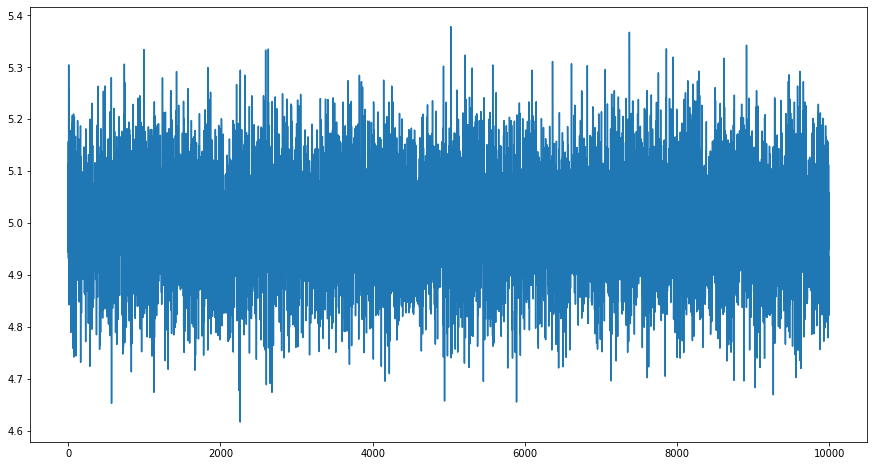

In [219]:
mean = 5
std = 0.1
num_samples = 10000
samples = np.random.normal(mean, std, size=num_samples)

print(samples)

source = {"samples_value": samples}
df= pd.DataFrame(source)

plt.figure(figsize=(15,8))
plt.plot(samples)
plt.show()

Powyższy wygenerowany diagram prezentuje szum biały składającego się z określonej liczby próbek zadeklarowanej w zmiennej <font color=yellow>num_samples</font>. Szum biały jest rodzajem szumu akustycznego, który posiada całkowicie płaskie widmo. W procesie stochastycznym szum biały to ciąg nieskorelowanych zmiennych losowych o zerowej wartości oczekiwanej i stałej wariancji(czyli biały szum to proces kowariancyjnie stacjonarny) oraz w sensie ścisłym to biały szum w którym nieskorelowanie wzmianiamy do niezależności. Biały szum jest tak zwaną ,,cegiełką" podczas konstrukcji procesów stochastycznych. 

### Wyświetlenie histogramu szumu białego o charakterze Gaussowskim

(array([  11.,  112.,  491., 1502., 2809., 2769., 1639.,  525.,  125.,
          17.]),
 array([4.61676816, 4.69290443, 4.7690407 , 4.84517697, 4.92131324,
        4.99744951, 5.07358578, 5.14972205, 5.22585832, 5.30199459,
        5.37813085]),
 <BarContainer object of 10 artists>)

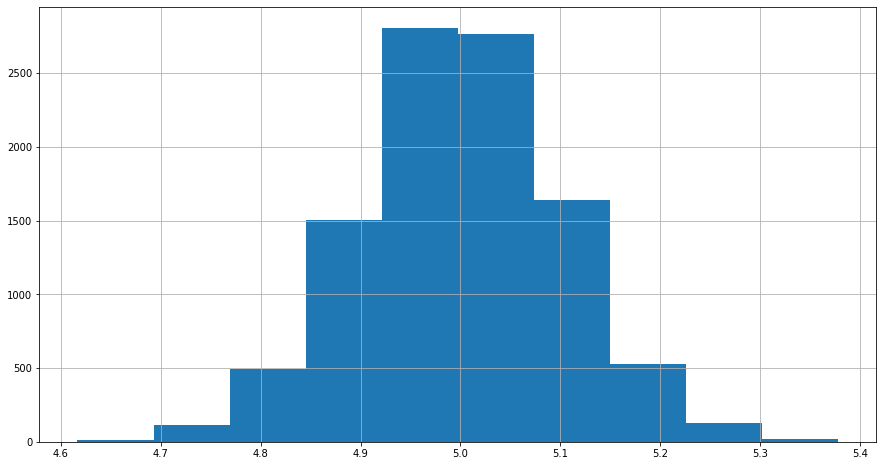

In [220]:
plt.figure(figsize=(15,8))
plt.grid()
plt.hist(samples)

## 2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwta, dystrybuantę, a też wartość oczekiwan, wariancję i funkcję kowariancyjną.

### Obliczenie gęstości prawdopodobieństwa

<font color=red>Uwaga aby wyświetlić gęstość prawdopodobieństwa należy posortować najpierw tablicę. Wytłumaczenie w linku poniżej</font>       
https://stackoverflow.com/questions/71296986/how-to-draw-the-probability-density-function-pdf-plot-in-python

Rozwiązanie 1

[0.00258072 0.00961228 0.01050263 ... 0.01133881 0.00468572 0.00313383]


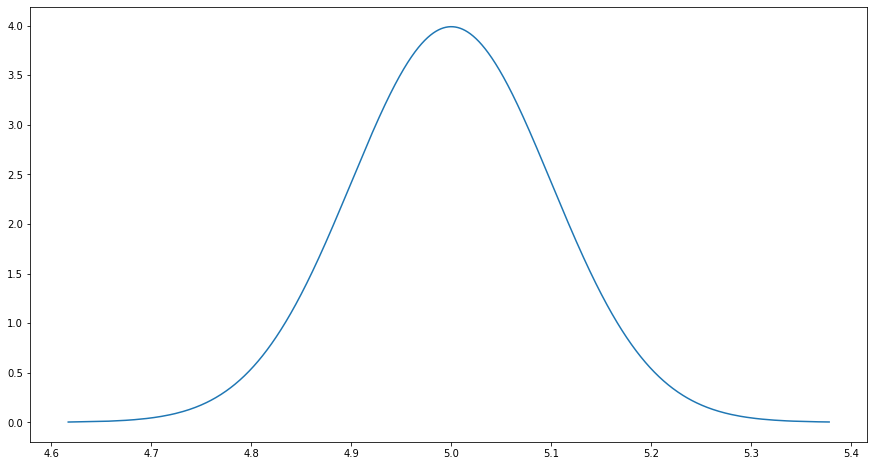

In [221]:
probability_pdf = norm.pdf(df["samples_value"].sort_values(), mean, std)
print(probability_pdf)

plt.figure(figsize=(15,8))
plt.plot(df["samples_value"].sort_values(), probability_pdf)

Rozwiązanie 2

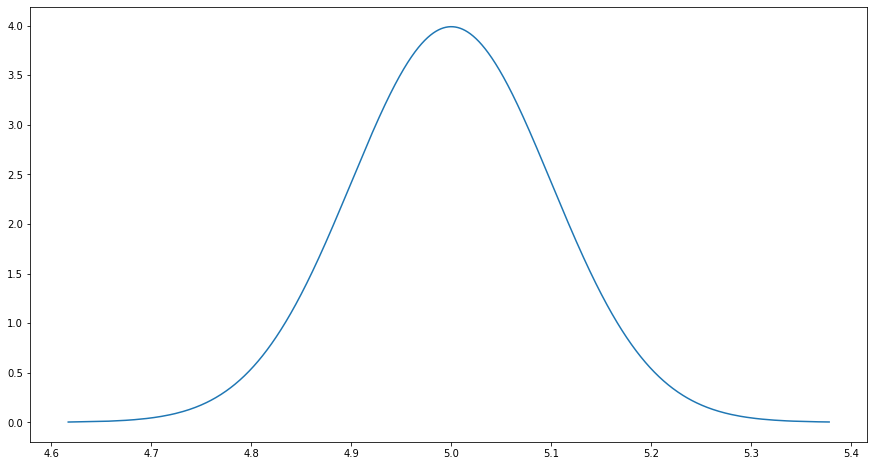

In [222]:
sort_samples = np.sort(samples)
probability_pdf = norm.pdf(sort_samples, mean, std)

plt.figure(figsize=(15,8))
plt.plot(sort_samples, probability_pdf)

### Obliczenie dystrybuanty

Podobnie jak dla obliczenia gęstości prawdopodobieństwa najpierw należało skorzystać z posortowanych wcześniej danych w tablicy <font color=yellow>samples</font>
https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python

(10000,)


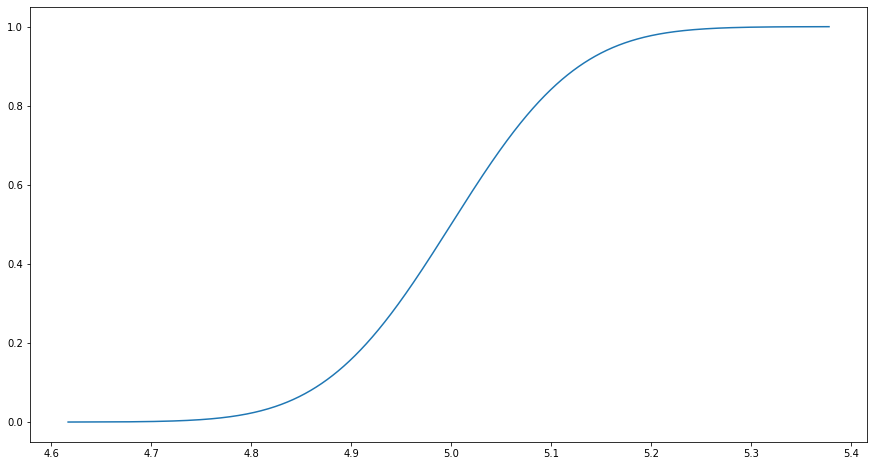

In [223]:
norm_cdf = norm.cdf(sort_samples, mean, std)
print(norm_cdf.shape)

plt.figure(figsize=(15,8))
plt.plot(sort_samples, norm_cdf)

### Obliczenie wartości oczekiwanej

Wytłumaczone na filmiku jak w pythonie obliczać wartość oczekiwaną oraz wariancję
https://www.youtube.com/watch?v=ikcUBqELZVU

In [224]:
expected_value = describe(samples).mean
print(expected_value)

4.9996666558455


### Obliczenie wariancji

In [225]:
variance = describe(samples).variance
print(variance)

0.010029124566437682


### Obliczenie funkcji kowariancyjnej

In [235]:
covariance_function = np.cov(samples, bias=True)
print(covariance_function)

0.01002812165398104
